# DSMarket - Clustering

### 1. Instalacion de paquetes 

In [1]:
!pip install seaborn
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 2. Importacion de librerias

In [2]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# operating system
import os

# time calculation to track some processes
import time

# numeric and matrix operations
import numpy as np
import pandas as pd

# loading ploting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# python core library for machine learning and data science
import sklearn
from sklearn import set_config
set_config(transform_output = "pandas")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 3. Carga de datos

In [3]:
df = pd.read_parquet("df_sales_week.parquet", engine="pyarrow")
print(df.shape)
df.head(3)

(8354260, 12)


,id,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event
1,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl
2,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201107,0,0.0,12.7414,Valentine's Day


## 4. Exploratory Data Analysis (EDA)

In [4]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print(df.info(verbose = verbose))
    total_nulos = df.isnull().sum().sum()
    print()
    print(f"Tenemos un total de {total_nulos} nulos")

def unique_counts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Retorna un DataFrame con la cantidad de valores únicos por columna.
    
    Parámetros:
        df (pd.DataFrame): DataFrame de entrada
    
    Retorna:
        pd.DataFrame: columnas y cantidad de valores únicos
    """
    result = pd.DataFrame({
        "columna": df.columns,
        "valores_unicos": [df[col].nunique(dropna=False) for col in df.columns]
    })
    return result

In [5]:
report_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8354260 entries, 0 to 8354259
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              object 
 1   item            object 
 2   category        object 
 3   department      object 
 4   store           object 
 5   store_code      object 
 6   region          object 
 7   yearweek        int64  
 8   n_sales         int64  
 9   revenue         float64
 10  avg_sell_price  float64
 11  event           object 
dtypes: float64(2), int64(2), object(8)
memory usage: 764.9+ MB
None

Tenemos un total de 0 nulos


In [6]:
unique_counts(df)

,columna,valores_unicos
0,id,30490
1,item,3049
2,category,3
3,department,7
4,store,10
5,store_code,10
6,region,3
7,yearweek,274
8,n_sales,1099
9,revenue,50724


In [7]:
# Asignar 'id' como índice
df = df.set_index("id", drop=True)

In [8]:
df.head(3)

,item,category,department,store,store_code,region,yearweek,n_sales,revenue,avg_sell_price,event
id,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201105,0,0.0,12.7414,Without event
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201106,0,0.0,12.7414,SuperBowl
ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,South_End,BOS_1,Boston,201107,0,0.0,12.7414,Valentine's Day


## 5. Clustering productos

### 5.1. Agrupar ventas por producto-semana

In [9]:
df_items = (
    df.groupby(["item", "category", "department", "yearweek", "event"], as_index=False)
    .agg(
        n_sales=("n_sales", "sum"),
        revenue=("revenue", "sum"),
        avg_sell_price=("avg_sell_price", "mean"),
    )
)

In [10]:
df_items

,item,category,department,yearweek,event,n_sales,revenue,avg_sell_price
0,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201105,Without event,0,0.0,11.95936
1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201106,SuperBowl,0,0.0,11.95936
2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201107,Valentine's Day,0,0.0,11.95936
3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201108,Without event,0,0.0,11.95936
4,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,201109,Without event,0,0.0,11.95936
...,...,...,...,...,...,...,...,...
835421,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201613,Easter,167,200.4,1.20000
835422,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201614,Without event,205,246.0,1.20000
835423,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201615,Without event,167,200.4,1.20000
835424,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,201616,Without event,186,223.2,1.20000


### 5.2. Agregar features

In [11]:
# Features básicos por item
features_item = (
    df_items.groupby("item")
    .agg(
        mean_sales=("n_sales", "mean"),
        std_sales=("n_sales", "std"),
        max_sales=("n_sales", "max"),
        min_sales=("n_sales", "min"),
        mean_revenue=("revenue", "mean"),
        std_revenue=("revenue", "std"),
        total_sales=("n_sales", "sum"),
        total_revenue=("revenue", "sum"),
        avg_price=("avg_sell_price", "mean"),
    )
    .reset_index()
)

# Coeficiente de variación
# features_item["cv_sales"] = features_item["std_sales"] / features_item["mean_sales"].replace(0, np.nan)
features_item["cv_revenue"] = features_item["std_revenue"] / features_item["mean_revenue"].replace(0, np.nan)

# % semanas con 0 ventas
pct_zero = (
    df_items.groupby("item")["n_sales"]
    .apply(lambda x: (x == 0).mean())
    .reset_index(name="pct_weeks_zero")
)

# % de ventas en semanas con evento
sales_event = (
    df_items.groupby(["item", "event"])["n_sales"].sum().reset_index()
)

sales_event_flag = (
    sales_event.groupby("item")
    .apply(lambda x: x.loc[x["event"] != "Without event", "n_sales"].sum() / x["n_sales"].sum())
    .reset_index(name="pct_sales_event")
)

# Unir todo
features_item = (
    features_item
    .merge(pct_zero, on="item", how="left")
    .merge(sales_event_flag, on="item", how="left")
    .fillna({"pct_sales_event": 0})
)


In [12]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event
0,ACCESORIES_1_001,14.937956,15.317871,58,0,164.371399,168.393424,4093,45037.7634,11.467561,1.024469,0.467153,0.298803
1,ACCESORIES_1_002,18.463504,10.965837,102,0,97.474729,57.902918,5059,26708.0758,5.276746,0.594030,0.062044,0.320617
2,ACCESORIES_1_003,5.237226,7.646872,37,0,20.643590,30.192925,1435,5656.3437,3.947629,1.462581,0.591241,0.340070


### 5.3. Establecer numero de clusters

In [13]:
# Selección dinámica solo de variables numéricas
X = (
    features_item
    .select_dtypes(include=[np.number])   # solo numéricas
    .replace([np.inf, -np.inf], np.nan)   # manejar infinitos
    .fillna(0.0)                          # manejar nulos
)

In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
sse = {}
for k in range(2, 15):   # probamos de 2 a 14 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    kmeans.fit(X_scaled)
    sse[k] = kmeans.inertia_


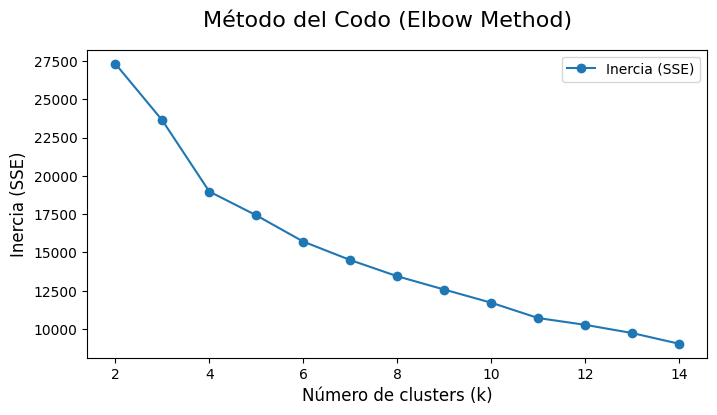

In [16]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, marker="o", label="Inercia (SSE)")
ax.set_xlabel("Número de clusters (k)", fontsize=12)
ax.set_ylabel("Inercia (SSE)", fontsize=12)
ax.legend()
fig.suptitle("Método del Codo (Elbow Method)", fontsize=16)
plt.show()

### 5.4. Creacion de pipeline

In [17]:
# Definir pipeline
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("kmeans", KMeans(n_clusters=4, random_state=175, n_init="auto"))
])

# Entrenar modelo
pipeline.fit(X)

# Obtener etiquetas de cluster
features_item["cluster"] = pipeline["kmeans"].labels_

In [18]:
# Distribución por cluster
print(features_item["cluster"].value_counts())

cluster
3    1787
0     955
1     285
2      22
Name: count, dtype: int64


In [19]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event,cluster
0,ACCESORIES_1_001,14.937956,15.317871,58,0,164.371399,168.393424,4093,45037.7634,11.467561,1.024469,0.467153,0.298803,0
1,ACCESORIES_1_002,18.463504,10.965837,102,0,97.474729,57.902918,5059,26708.0758,5.276746,0.594030,0.062044,0.320617,3
2,ACCESORIES_1_003,5.237226,7.646872,37,0,20.643590,30.192925,1435,5656.3437,3.947629,1.462581,0.591241,0.340070,0


In [20]:
# Tomar las columnas categóricas únicas por item
df_cats = df_items[["item", "category", "department"]].drop_duplicates("item")

# Unirlas con tus features agregados
features_item = features_item.merge(df_cats, on="item", how="left")

In [21]:
df_items.shape

(835426, 8)

In [22]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event,cluster,category,department
0,ACCESORIES_1_001,14.937956,15.317871,58,0,164.371399,168.393424,4093,45037.7634,11.467561,1.024469,0.467153,0.298803,0,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,18.463504,10.965837,102,0,97.474729,57.902918,5059,26708.0758,5.276746,0.594030,0.062044,0.320617,3,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,5.237226,7.646872,37,0,20.643590,30.192925,1435,5656.3437,3.947629,1.462581,0.591241,0.340070,0,ACCESORIES,ACCESORIES_1


In [23]:
features_item.to_csv("clustering_data.csv", index=False, encoding="utf-8")

In [24]:
pipeline["kmeans"].labels_.shape

(3049,)

In [25]:
pipeline[:2]

,steps,"[('scaler', ...), ('kmeans', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300


In [26]:
features_item["cluster"] = pipeline["kmeans"].labels_

In [27]:
features_item.head(3)

,item,mean_sales,std_sales,max_sales,min_sales,mean_revenue,std_revenue,total_sales,total_revenue,avg_price,cv_revenue,pct_weeks_zero,pct_sales_event,cluster,category,department
0,ACCESORIES_1_001,14.937956,15.317871,58,0,164.371399,168.393424,4093,45037.7634,11.467561,1.024469,0.467153,0.298803,0,ACCESORIES,ACCESORIES_1
1,ACCESORIES_1_002,18.463504,10.965837,102,0,97.474729,57.902918,5059,26708.0758,5.276746,0.594030,0.062044,0.320617,3,ACCESORIES,ACCESORIES_1
2,ACCESORIES_1_003,5.237226,7.646872,37,0,20.643590,30.192925,1435,5656.3437,3.947629,1.462581,0.591241,0.340070,0,ACCESORIES,ACCESORIES_1


### 5.5. Verificacion de clusters por feature

In [28]:
(
    features_item
    .groupby(["cluster"])
    .describe()
    .T
    .style
    .format('{:.2f}')
    .background_gradient(cmap = 'Blues', axis = 1)
)

## 6. Ficha de productos

In [29]:
ficha_df = pd.DataFrame()

In [30]:
for i, col in enumerate(["pct_weeks_zero", "total_sales", "pct_sales_event", "avg_price"]):
    resumen_data = features_item[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = pd.concat([ficha_df, resumen_data])

In [31]:
ficha_df

cluster                          0              1             2             3
pct_weeks_zero  mean      0.514744       0.111000  1.368613e-01      0.083286
                std       0.133191       0.134874  2.040216e-01      0.093498
                min       0.131387       0.000000  0.000000e+00      0.000000
                25%       0.405109       0.000000  0.000000e+00      0.000000
                50%       0.500000       0.054745  4.197080e-02      0.043796
                75%       0.614964       0.193431  1.788321e-01      0.149635
                max       0.843066       0.594891  6.715328e-01      0.368613
total_sales     mean   7025.112042   84891.315789  3.505252e+05  15154.363179
                std    7094.027611   49405.191039  2.308117e+05  13172.242012
                min     568.000000   11716.000000  2.932000e+04    660.000000
                25%    2450.500000   51553.000000  2.611110e+05   5849.500000
                50%    4590.000000   74406.000000  2.826190e+05  11175.000000
                75%    8863.500000  109692.000000  3.945895e+05  20540.500000
                max   54616.000000  257119.000000  1.002529e+06  90433.000000
pct_sales_event mean      0.290812       0.295287  2.950364e-01      0.290120
                std       0.023477       0.025409  1.643430e-02      0.015829
                min       0.204729       0.249289  2.600761e-01      0.223824
                25%       0.277220       0.284252  2.871266e-01      0.281583
                50%       0.289794       0.292022  2.972856e-01      0.289825
                75%       0.303062       0.301647  3.015886e-01      0.298275
                max       0.419637       0.523210  3.328798e-01      0.418196
avg_price       mean      5.801029       4.658864  3.886430e+00      5.600374
                std       4.940629       4.936019  6.218438e+00      4.184768
                min       0.305900       0.239668  1.175632e+00      0.305900
                25%       2.754201       1.274825  1.688126e+00      2.945975
                50%       3.950100       2.993676  1.912139e+00      4.547208
                75%       7.219690       5.573440  3.015388e+00      7.300000
                max      37.599100      28.696633  3.068060e+01     39.444270

In [32]:
# generamos nuestro multiindex
out_index = [
    "Ventas",
    "Rotacion",
    "Estacionalidad",
    "Costo"
]

inner_index = [
    "pct_weeks_zero", "total_sales", "pct_sales_event", "avg_price"
]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [33]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [34]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [35]:
tamaño_clusters = features_item.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [36]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])

In [37]:
ficha_df

cluster                                                   0              1  \
Grupo Indicadores Indicador       Estadístico                                
General           Clúster         Tamaño         955.000000     285.000000   
Ventas            pct_weeks_zero  Media            0.514744       0.111000   
                                  Desviación       0.133191       0.134874   
                                  Mínimo           0.131387       0.000000   
                                  Perc. 25         0.405109       0.000000   
                                  Perc. 50         0.500000       0.054745   
                                  Perc. 75         0.614964       0.193431   
                                  Máximo           0.843066       0.594891   
Rotacion          total_sales     Media         7025.112042   84891.315789   
                                  Desviación    7094.027611   49405.191039   
                                  Mínimo         568.000000   11716.000000   
                                  Perc. 25      2450.500000   51553.000000   
                                  Perc. 50      4590.000000   74406.000000   
                                  Perc. 75      8863.500000  109692.000000   
                                  Máximo       54616.000000  257119.000000   
Estacionalidad    pct_sales_event Media            0.290812       0.295287   
                                  Desviación       0.023477       0.025409   
                                  Mínimo           0.204729       0.249289   
                                  Perc. 25         0.277220       0.284252   
                                  Perc. 50         0.289794       0.292022   
                                  Perc. 75         0.303062       0.301647   
                                  Máximo           0.419637       0.523210   
Costo             avg_price       Media            5.801029       4.658864   
                                  Desviación       4.940629       4.936019   
                                  Mínimo           0.305900       0.239668   
                                  Perc. 25         2.754201       1.274825   
                                  Perc. 50         3.950100       2.993676   
                                  Perc. 75         7.219690       5.573440   
                                  Máximo          37.599100      28.696633   

cluster                                                   2             3  
Grupo Indicadores Indicador       Estadístico                              
General           Clúster         Tamaño       2.200000e+01   1787.000000  
Ventas            pct_weeks_zero  Media        1.368613e-01      0.083286  
                                  Desviación   2.040216e-01      0.093498  
                                  Mínimo       0.000000e+00      0.000000  
                                  Perc. 25     0.000000e+00      0.000000  
                                  Perc. 50     4.197080e-02      0.043796  
                                  Perc. 75     1.788321e-01      0.149635  
                                  Máximo       6.715328e-01      0.368613  
Rotacion          total_sales     Media        3.505252e+05  15154.363179  
                                  Desviación   2.308117e+05  13172.242012  
                                  Mínimo       2.932000e+04    660.000000  
                                  Perc. 25     2.611110e+05   5849.500000  
                                  Perc. 50     2.826190e+05  11175.000000  
                                  Perc. 75     3.945895e+05  20540.500000  
                                  Máximo       1.002529e+06  90433.000000  
Estacionalidad    pct_sales_event Media        2.950364e-01      0.290120  
                                  Desviación   1.643430e-02      0.015829  
                                  Mínimo       2.600761e-01      0.223824  
                                  Perc. 25     2.871266e-01  

In [38]:
float_format = '{:.2f}'

In [41]:
(
    ficha_df
    .rename(columns = {
        0 : "Menor Rotacion",
        1 : "Eventos",
        2 : "Top Ventas",
        3 : "Alto valor"
    })
    .style
    .format(float_format)
    .background_gradient(cmap = 'Blues', axis = 1)
)